In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pydataset import data
import numpy as np
import os
import scipy.stats as stats
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report
alpha = 0.05

import prepare as p
import model as m
import explore as e
import acquire as a
from env import get_db_url

#turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")

# aquiring raw data

In [2]:
df = a.get_comet_data()

In [3]:
df.head(3)

,full_name,e,q,i,om,w,ad,tp_cal,per_y,class,data_arc,condition_code,n_obs_used,two_body,A1,A2,A3,DT
0,C/-146 P1,1.0,0.43,71.0,330.0,261.0,NaN,-146-06-28.0,NaN,PAR,5.0,NaN,4.0,T,NaN,NaN,NaN,NaN
1,C/-43 K1,1.0,0.22,110.0,170.0,17.0,NaN,-043-05-25.0,NaN,PAR,54.0,NaN,NaN,T,NaN,NaN,NaN,NaN
2,C/240 V1,1.0,0.37,44.0,214.0,82.0,NaN,0240-11-10.0,NaN,PAR,39.0,NaN,NaN,T,NaN,NaN,NaN,NaN


# preparing data

| Feature | Definition | Reason |
|:--------|:-----------|:----------|
|<img width=50/>|<img width=100/>|<img width=50/>|<img width=150/>|
|||**Dropped Columns**
|<img width=50/>|<img width=100/>|<img width=50/>|<img width=150/>|
|*e*|  eccentricity | The eccentricity defines the orbit class
|*A1*| non-grav radial parameter | Excessive null values
|*A2*| non-grav transverse parameter | Excessive null values
|*A3*| non-grav normal parameter | Excessive null values
|*D*| non-gravperihelion maximum offset | Excessive null values
|||**Dropped Rows**
<img width=50/>|<img width=100/>|<img width=50/>|<img width=150/>|
|*2 rows for tp_cal*| time of perihelion calculated | Dates were negative; assuming this means B.C.E
|*3 rows for data_arc *| Number of days spanned by the data arc | null values could not be imputed
|||**Altered Data**
||<img width=150/>|<img width=550/>|
|*tp_cal*| time of perihelion calculated | object data type could not be converted in Pandas as the time span is too large. Modified by dropping month, day, and time information. Resulting year was converted to int64|
|*two_body*| two-body dynamics used | Original data was T/F. Used dummies to get three columns for True, False, and Nans
|*full_name*| the name of the comet | Fit to index|
|*All*| all columns | Name changed to be more human readable|

In [4]:
df = p.pre_processing(df)

In [5]:
df.head(3)

,orbit,perihelion,peri_distance,time_of_peri,inclination,node,days_of_data_arc,two_body_T,two_body_F,two_body_nan
full_name,,,,,,,,,,
C/240 V1,PAR,82.0,0.37,240,44.0,214.0,39.0,1,0,0
C/390 Q1,PAR,23.0,0.92,390,36.0,356.0,26.0,1,0,0
C/400 F1,PAR,47.0,0.21,400,32.0,38.0,22.0,1,0,0


| Feature | Definition | Layman's Terms |
|:--------|:-----------|:----------|
|<img width=50/>|<img width=100/>|<img width=50/>|<img width=150/>|
|||**Data**
|<img width=50/>|<img width=100/>|<img width=50/>|<img width=150/>|
|*perihelion*|  The point nearest to the sun in the path of an orbiting celestial body  | Where the comet is closest to the sun
|*peri_distance*| The distance between the sun and an orbiting body when it at perihelion | How far the comet is from the sun when it is as close as it gets to the sun
|*time_of_peri*| The calculated time period of perihelion | What day on Earth it was/will be when the comet was closest to the sun
|*inclination*| the angle between the orbital plane of the object and the plane of the ecliptic | Measures the tilt of the comet's orbit
|*node*| the intersection of the orbit plane of some celestial body with the plane of the ecliptic  | The point where inclination 'pokes through'
|*days_of_data_arc*| the time period between its earliest and latest observations, used for tracing the body's path | The number of days the comet could be observed
|||**Two Body**
|*two_body*| two-body dynamics used |
|*True *| Number of days spanned by the data arc | null values could not be imputed
|*False*| time of perihelion calculated | object data type could not be converted in Pandas as the time span is too large. Modified by dropping month, day, and time information. Resulting year was converted to int64|
|*nan*| two-body dynamics used | Original data was T/F. Used dummies to get three columns for True, False, and Nans


# Data Split

In [6]:
#splits data into three data frames called train, validate, and test
train, validate, test = p.split_data(df)

In [7]:
#splits the three data sets into six more witht the three y frames isolating the target variable
train_X, validate_X, test_X, train_y, validate_y, test_y = p.final_split(df, 'orbit')

# Exploration

 ### For this project I began my exploration by jumping right into statistical testing. I set parameters to separte the data based on orbit class and ran independedent T-tests comparing the means of all continuous features of Parabolic vs Hyperparabolic

### Based off the results of my independent T-test I determined the relevent features to be perihelion distance, the degree of the node, degree of perihelion, and the time of perihelion. So I generated histograms to explore these features.

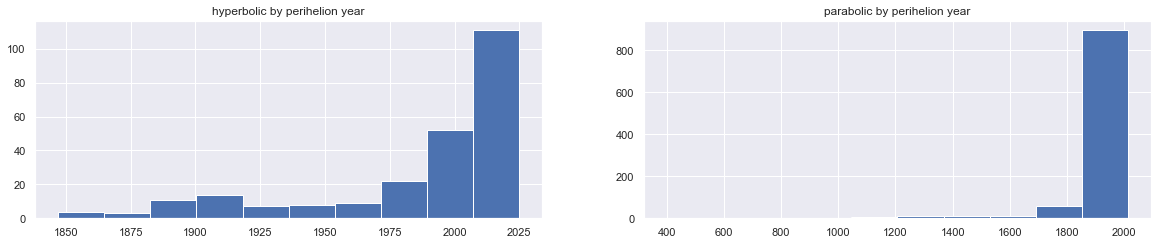

In [8]:
e.orbit_type_by_tp(train)

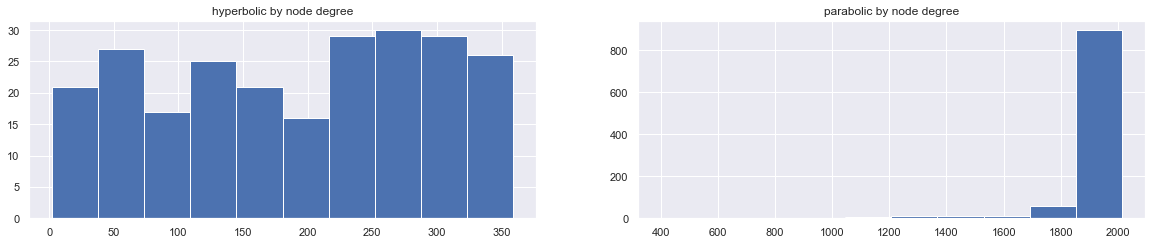

In [9]:
e.orbit_type_by_om(train)

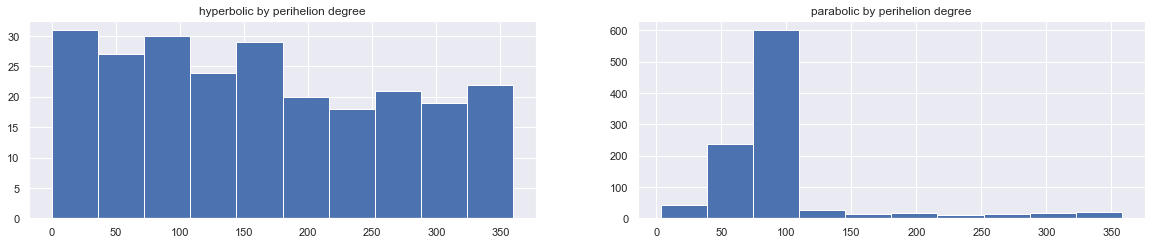

In [10]:
e.orbit_type_by_w(train)

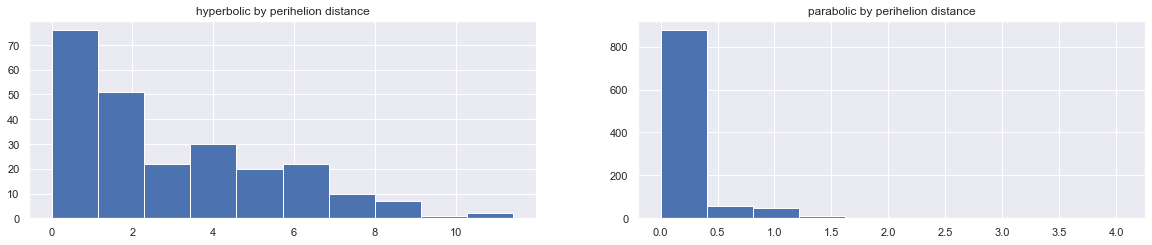

In [11]:
e.orbit_type_by_q(train)

### These visualizations made it clear, that my data is not normally distributed. I decided to go back and use an independent statistical test where normalization is not assumed. I used the Mann-Whitney test, and ran all the continuous features

In [12]:
e.Mann_Whitney_stats(train)

,Feature,t-stat,p-value
0,peri_distance,233151.0,3.260610e-120
1,inclination,66727.5,4.950020e-27
2,node,154727.5,7.224151e-12
3,perihelion,167204.0,8.659769e-21
4,time_of_peri,146470.5,1.912381e-07
5,days_of_data_arc,237270.5,8.897453e-134


### by this statistical test we can see that all features are significant and should be used to create the best model.

# Modeling

### Prepartaion for modeling requires scaling the data. I used a standard scaler

Standardization is a linear transformation of our data such that is looks like the standard normal distribution. That is, it will have a mean of 0 and a standard deviation of 1.

x
′
=
x
−
¯
x
σ
x
Sometimes this is split into two operations:

scaling is dividing each data point by the standard deviation. This causes the resulting dataset to have a standard deviation of 1.
centering is subtracting the mean from each data point. This causes the resulting dataset to have a mean of 0.

In [13]:
# here is a display of the mean, standard deviation, skew, 
# and sharpness of the original data
e.display_stat(train)

,Feature,Mean,Standard Deviation,Skew,Sharpness
0,peri_distance,0.690349,1.601073,3.164462,10.536952
1,inclination,118.911531,40.040322,-1.341428,0.572725
2,node,144.017607,141.700618,0.422364,-1.546508
3,perihelion,107.091386,75.447557,1.852627,2.659769
4,time_of_peri,1958.578566,155.883001,-5.688438,39.495091
5,days_of_data_arc,126.277196,377.852637,5.070218,38.327365


In [14]:
# scaling data
train_scaled, validate_scaled, test_scaled = m.Scaled_Data(train_X, validate_X, test_X)

In [15]:
# display of new stats after scaling
e.display_stat(train_scaled)

,Feature,Mean,Standard Deviation,Skew,Sharpness
0,peri_distance,-1.227418e-16,1.000403,3.164462,10.536952
1,inclination,3.023815e-16,1.000403,-1.341428,0.572725
2,node,7.622160e-17,1.000403,0.422364,-1.546508
3,perihelion,3.077492e-17,1.000403,1.852627,2.659769
4,time_of_peri,2.989819e-16,1.000403,-5.688438,39.495091
5,days_of_data_arc,3.086438e-18,1.000403,5.070218,38.327365


## Running the Models

In [16]:
m.model_results(train_scaled, validate_scaled, train_y, validate_y)

,Model,Train Accuracy,Validate Accuracy
0,KNN,0.979855,0.984991
1,Logistic Regression,0.986301,0.983114
2,Decision Tree,0.991942,0.984991
3,Random Forest,0.987107,0.988743


# amazing results! My model beat baseline by 20%

In [17]:
final_results = m.test_model(test_scaled, test_y)

Accuracy of Logistic Regression on train is 0.9707207207207207


# test model performed more poorly on the test dataset, but still beat baseline by 18%